<a href="https://colab.research.google.com/github/clementlemon02/M7-Stocks-Rolling-Forecast/blob/main/M7%20Stocks%20Rolling%20Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the dataset
df = pd.read_csv('m7_10y_final.csv')

# Display the first few rows of the dataset
df.head()


,Date,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_AdjClose,AAPL_Volume,AMZN_Open,AMZN_High,AMZN_Low,...,NVDA_Low,NVDA_Close,NVDA_AdjClose,NVDA_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_AdjClose,TSLA_Volume
0,2014-10-20 00:00:00,24.580000,24.990000,24.555000,24.940001,22.144411,310069200,15.1475,15.3265,15.1010,...,0.43250,0.43925,0.419952,200336000,15.114667,15.493333,15.034000,15.364667,15.364667,52416000
1,2014-10-21 00:00:00,25.754999,25.754999,25.317499,25.617500,22.745964,378495600,15.4950,15.7820,15.3535,...,0.44125,0.45800,0.437879,351092000,15.618000,15.692667,15.386667,15.689333,15.689333,61954500
2,2014-10-22 00:00:00,25.709999,26.027500,25.650000,25.747499,22.861397,273052400,15.7715,15.9490,15.6320,...,0.44725,0.44725,0.427601,239512000,15.546000,15.826000,15.370667,15.406667,15.406667,61749000
3,2014-10-23 00:00:00,26.020000,26.262501,25.907499,26.207500,23.269831,284298800,15.6700,15.8400,15.5700,...,0.45175,0.45725,0.437162,214476000,15.644000,15.752000,15.466667,15.686000,15.686000,52386000
4,2014-10-24 00:00:00,26.295000,26.372499,26.132500,26.305000,23.356396,188215600,14.2200,14.6905,14.2000,...,0.45725,0.46200,0.441703,210156000,15.751333,15.853333,15.413333,15.682667,15.682667,51949500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2516 non-null   object 
 1   AAPL_Open       2516 non-null   float64
 2   AAPL_High       2516 non-null   float64
 3   AAPL_Low        2516 non-null   float64
 4   AAPL_Close      2516 non-null   float64
 5   AAPL_AdjClose   2516 non-null   float64
 6   AAPL_Volume     2516 non-null   int64  
 7   AMZN_Open       2516 non-null   float64
 8   AMZN_High       2516 non-null   float64
 9   AMZN_Low        2516 non-null   float64
 10  AMZN_Close      2516 non-null   float64
 11  AMZN_AdjClose   2516 non-null   float64
 12  AMZN_Volume     2516 non-null   int64  
 13  GOOGL_Open      2516 non-null   float64
 14  GOOGL_High      2516 non-null   float64
 15  GOOGL_Low       2516 non-null   float64
 16  GOOGL_Close     2516 non-null   float64
 17  GOOGL_AdjClose  2516 non-null   f

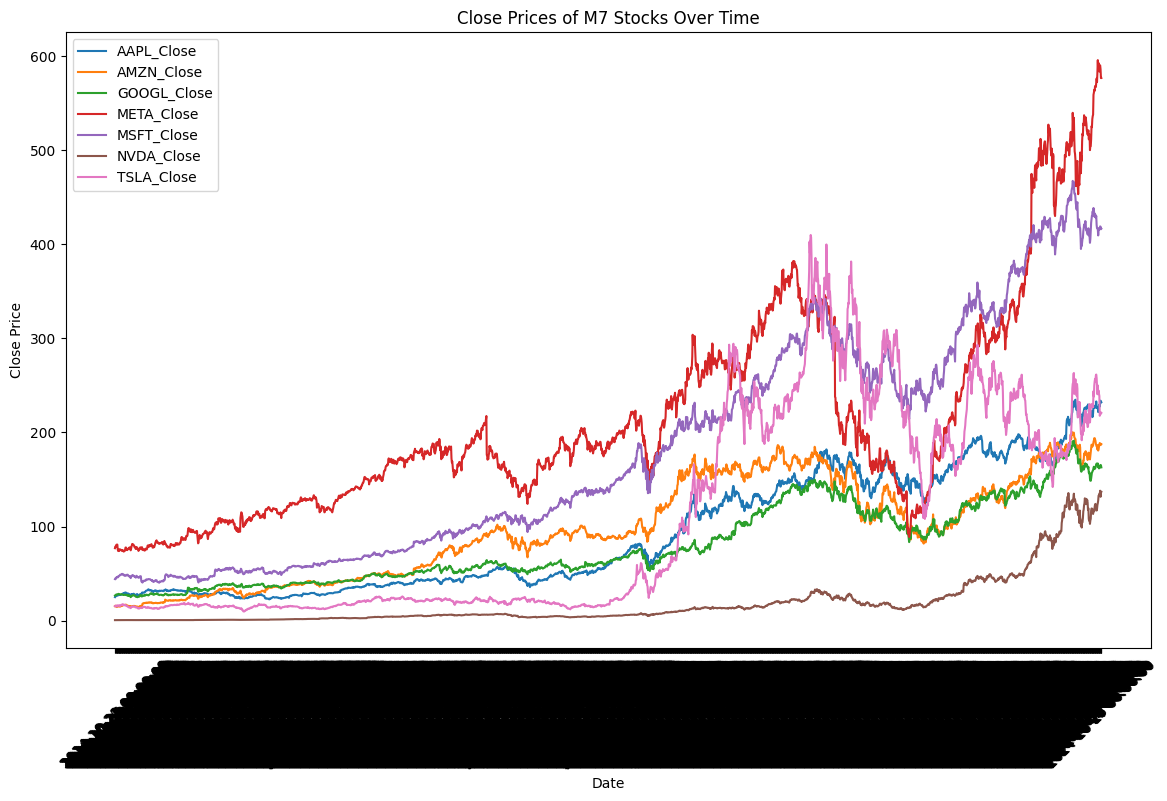

In [4]:
# Check the shape of the dataset and basic information
df.info()

# Summary statistics for all stocks
df.describe()

# Plotting the Close prices of each stock over time
stocks = ['AAPL_Close', 'AMZN_Close', 'GOOGL_Close', 'META_Close', 'MSFT_Close', 'NVDA_Close', 'TSLA_Close']

plt.figure(figsize=(14, 8))
for stock in stocks:
    plt.plot(df['Date'], df[stock], label=stock)
plt.title('Close Prices of M7 Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


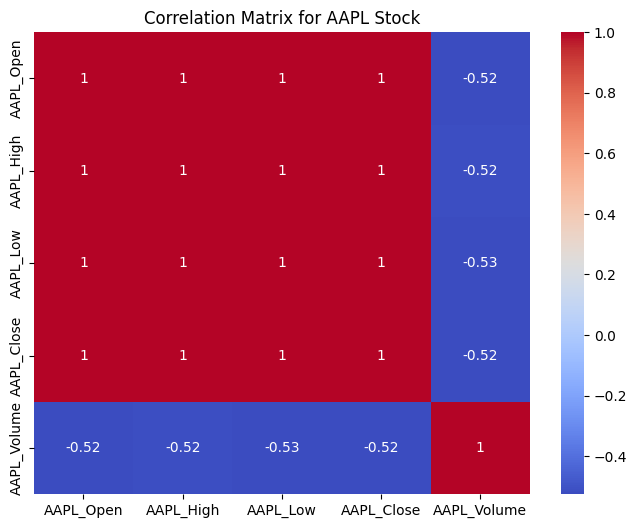

In [5]:
# Correlation matrix for AAPL stock (you can do the same for other stocks)
corr_aapl = df[['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume']].corr()

# Plot the correlation heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(corr_aapl, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix for AAPL Stock')
plt.show()


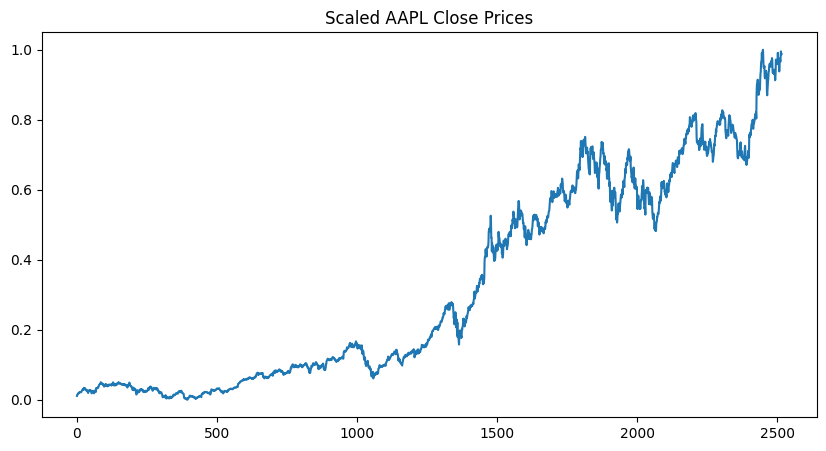

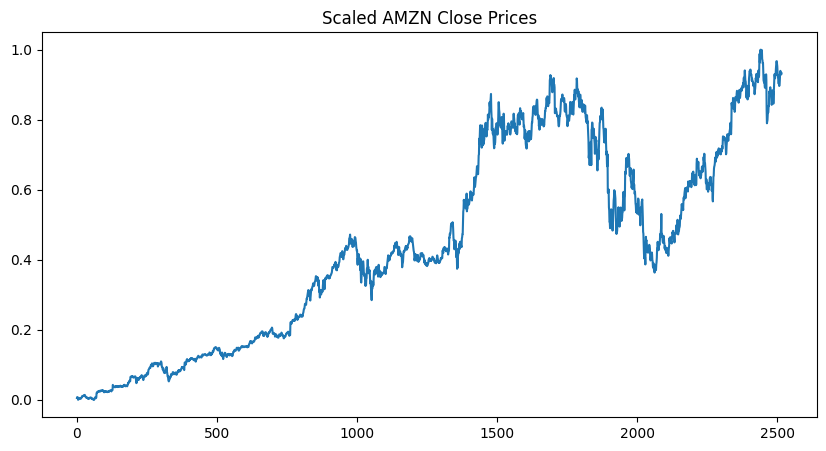

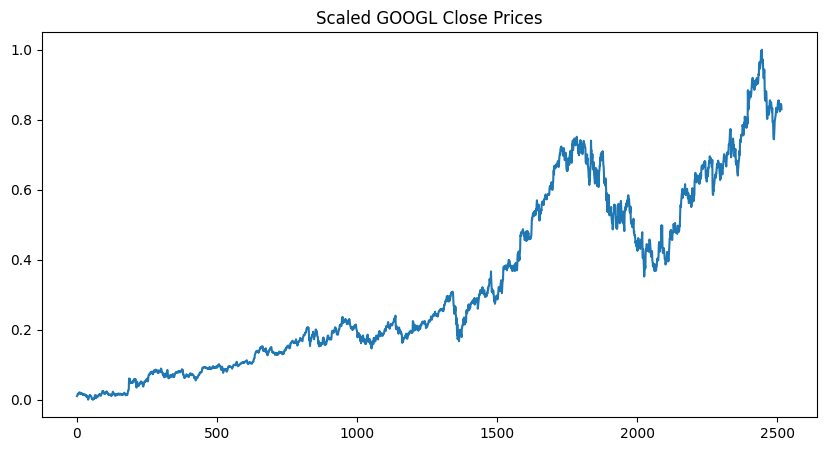

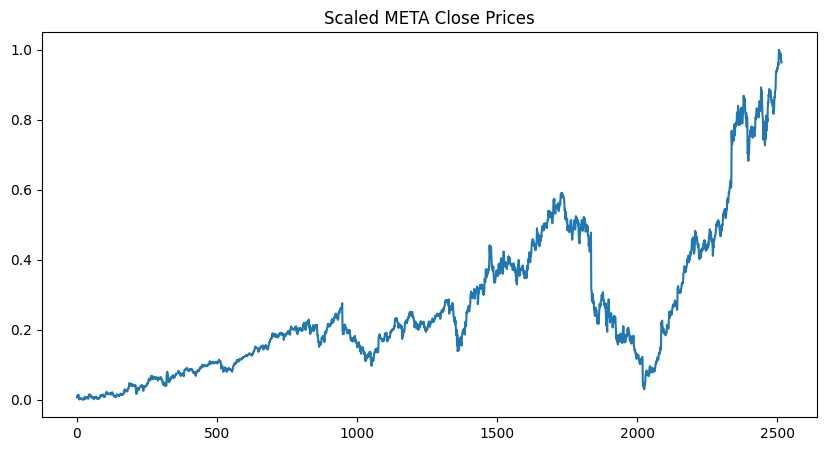

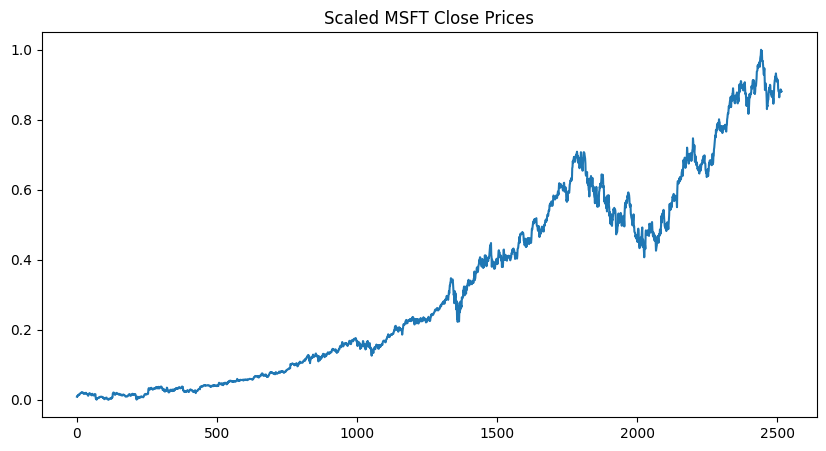

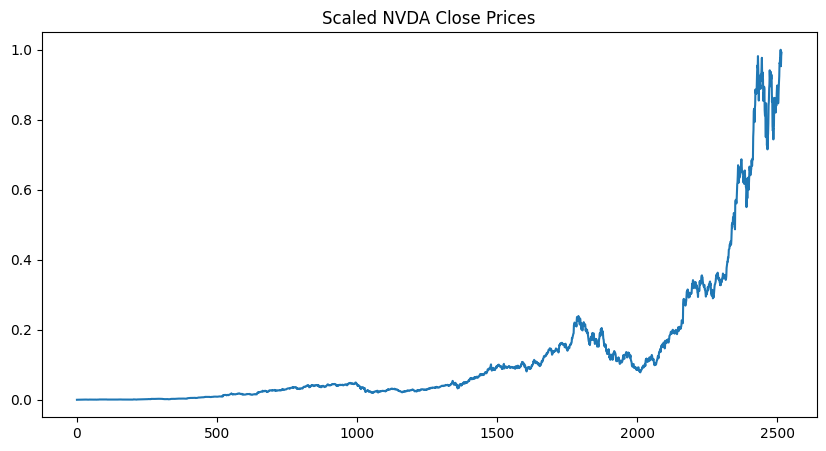

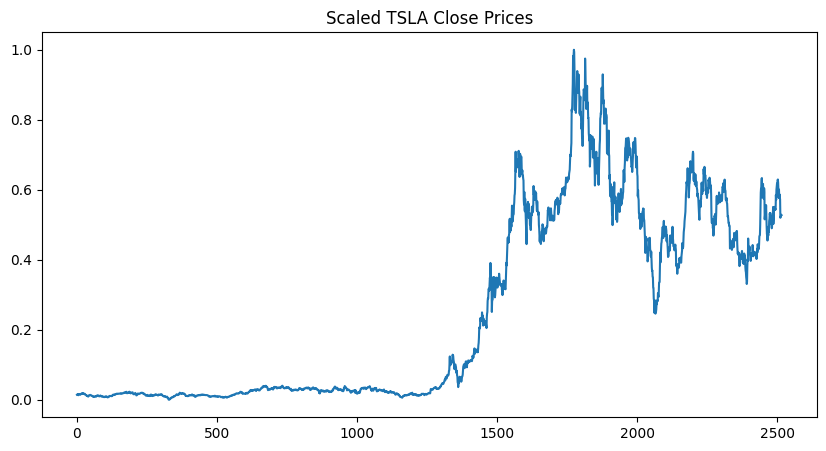

In [6]:
# List of M7 stocks
stocks = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

# Initialize a dictionary to store the processed data
data_dict = {}

# Data preparation for each stock
for stock in stocks:
    # Select relevant columns for the current stock
    features = [f'{stock}_Open', f'{stock}_High', f'{stock}_Low', f'{stock}_Close', f'{stock}_Volume']
    data = df[features].dropna()

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Store the scaled data and scaler for future use
    data_dict[stock] = (scaled_data, scaler)

    # Visualize the scaled close prices
    plt.figure(figsize=(10, 5))
    plt.plot(scaled_data[:, 3], label=f'{stock} Scaled Close Price')
    plt.title(f'Scaled {stock} Close Prices')
    plt.show()


In [7]:
# Function to create rolling windows
def create_rolling_window(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X.append(data[i:i+window_size, :])  # Use all features as inputs
        y.append(data[i+window_size, 3])  # Only the 'Close' price as output (index 3 in the features list)
    return np.array(X), np.array(y)

# Create rolling windows and split data for each stock
window_size = 60
forecast_horizon = 1

split_data = {}

for stock, (scaled_data, scaler) in data_dict.items():
    # Create rolling windows
    X, y = create_rolling_window(scaled_data, window_size, forecast_horizon)

    # Split into training, validation, and test sets (80% train, 10% val, 10% test)
    train_size = int(0.8 * len(X))
    val_size = int(0.1 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

    # Store the split data for each stock
    split_data[stock] = (X_train, y_train, X_val, y_val, X_test, y_test)

    # Display the shape of the data for each stock
    print(f'{stock} - Training Data Shape: {X_train.shape}, Validation Data Shape: {X_val.shape}, Test Data Shape: {X_test.shape}')


AAPL - Training Data Shape: (1964, 60, 5), Validation Data Shape: (245, 60, 5), Test Data Shape: (246, 60, 5)
AMZN - Training Data Shape: (1964, 60, 5), Validation Data Shape: (245, 60, 5), Test Data Shape: (246, 60, 5)
GOOGL - Training Data Shape: (1964, 60, 5), Validation Data Shape: (245, 60, 5), Test Data Shape: (246, 60, 5)
META - Training Data Shape: (1964, 60, 5), Validation Data Shape: (245, 60, 5), Test Data Shape: (246, 60, 5)
MSFT - Training Data Shape: (1964, 60, 5), Validation Data Shape: (245, 60, 5), Test Data Shape: (246, 60, 5)
NVDA - Training Data Shape: (1964, 60, 5), Validation Data Shape: (245, 60, 5), Test Data Shape: (246, 60, 5)
TSLA - Training Data Shape: (1964, 60, 5), Validation Data Shape: (245, 60, 5), Test Data Shape: (246, 60, 5)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0074 - val_loss: 6.7956e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.9507e-04 - val_loss: 6.4999e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.6702e-04 - val_loss: 5.9854e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5176e-04 - val_loss: 6.0016e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.3739e-04 - val_loss: 4.6975e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.8897e-04 - val_loss: 4.8692e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.6721e-04 - val_loss: 4.9927e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.8545e-04 - val_loss: 7.2087e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.9510e-04 - val_loss: 4.1812e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6734e-04 - val_loss: 3.1280e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8357e-04 - v

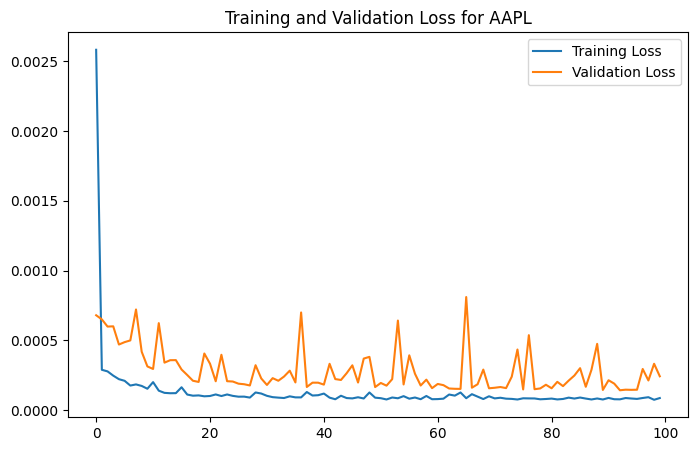

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0163 - val_loss: 8.3801e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 7.1963e-04 - val_loss: 8.0271e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.3336e-04 - val_loss: 7.3430e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.2279e-04 - val_loss: 5.6773e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.6425e-04 - val_loss: 5.0954e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.9166e-04 - val_loss: 4.7468e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.9887e-04 - val_loss: 4.6637e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.7075e-04 - val_loss: 4.2984e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.7399e-04 - val_loss: 3.9736e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.9160e-04 - val_loss: 3.5397e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.

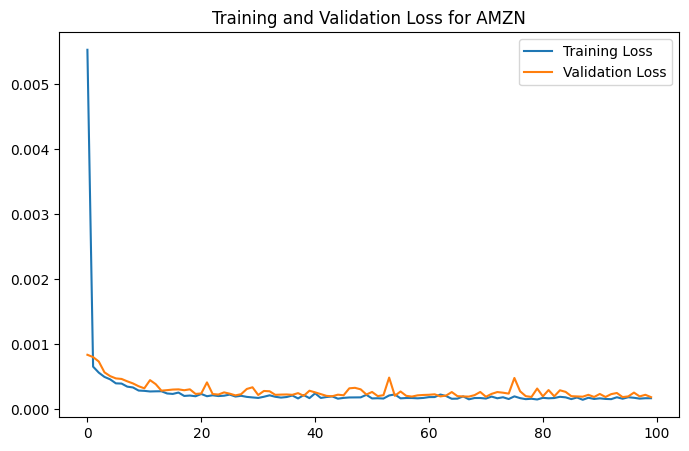

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0224 - val_loss: 0.0012
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.2166e-04 - val_loss: 9.0361e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.8756e-04 - val_loss: 6.6797e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4714e-04 - val_loss: 9.4697e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.3793e-04 - val_loss: 7.8489e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.1767e-04 - val_loss: 7.0450e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.1659e-04 - val_loss: 5.6476e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.9462e-04 - val_loss: 5.6391e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9418e-04 - val_loss: 5.2012e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.6919e-04 - val_loss: 5.5988e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.5765

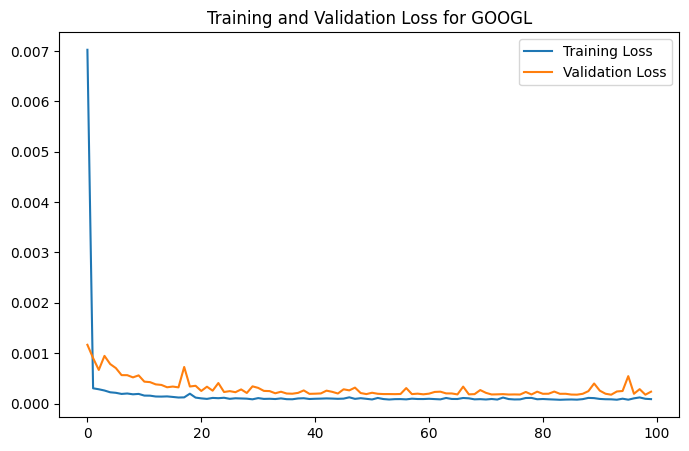

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0147 - val_loss: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.8317e-04 - val_loss: 6.7797e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.3494e-04 - val_loss: 4.3472e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.5039e-04 - val_loss: 5.4566e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.2800e-04 - val_loss: 3.7671e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.0735e-04 - val_loss: 3.9915e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.9031e-04 - val_loss: 3.6180e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.9071e-04 - val_loss: 3.2569e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8579e-04 - val_loss: 3.0620e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.9560e-04 - val_loss: 4.3932e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.6508

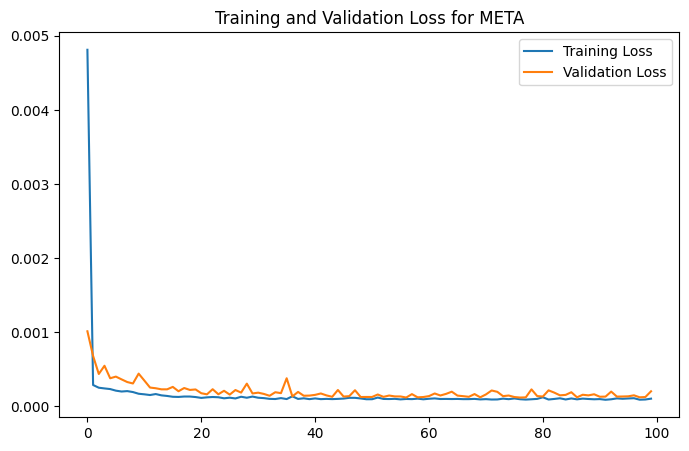

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0234 - val_loss: 6.2480e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.1581e-04 - val_loss: 5.3999e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.1937e-04 - val_loss: 5.2762e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.0017e-04 - val_loss: 4.7745e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.9282e-04 - val_loss: 4.7380e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.0742e-04 - val_loss: 4.6286e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7372e-04 - val_loss: 4.2480e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.6289e-04 - val_loss: 5.2047e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 1.7875e-04 - val_loss: 3.9443e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.4720e-04 - val_loss: 3.8593e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.

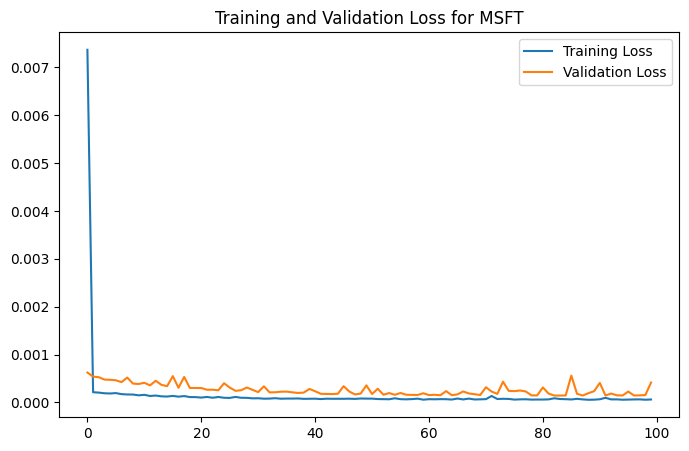

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0015 - val_loss: 2.4384e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.2864e-05 - val_loss: 2.8228e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.0773e-05 - val_loss: 2.3361e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.6037e-05 - val_loss: 1.8347e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8026e-05 - val_loss: 1.6671e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.8141e-05 - val_loss: 1.5764e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.6053e-05 - val_loss: 1.5002e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.2577e-05 - val_loss: 1.3730e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.8949e-05 - val_loss: 1.5928e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0046e-05 - val_loss: 1.3314e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.

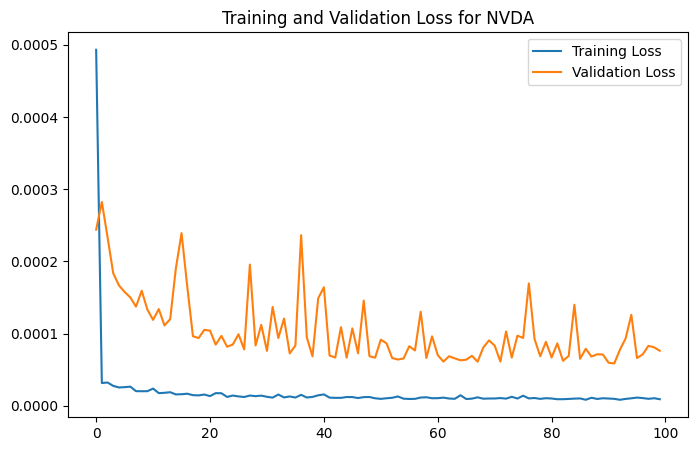

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0126 - val_loss: 0.0021
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.7026e-04 - val_loss: 0.0017
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.1668e-04 - val_loss: 0.0014
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.7867e-04 - val_loss: 0.0011
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.8591e-04 - val_loss: 8.9507e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.9489e-04 - val_loss: 0.0012
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.5066e-04 - val_loss: 7.0860e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8018e-04 - val_loss: 7.2151e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.3466e-04 - val_loss: 0.0011
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.3538e-04 - val_loss: 9.5178e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.0757e-04 - val_loss: 8.2

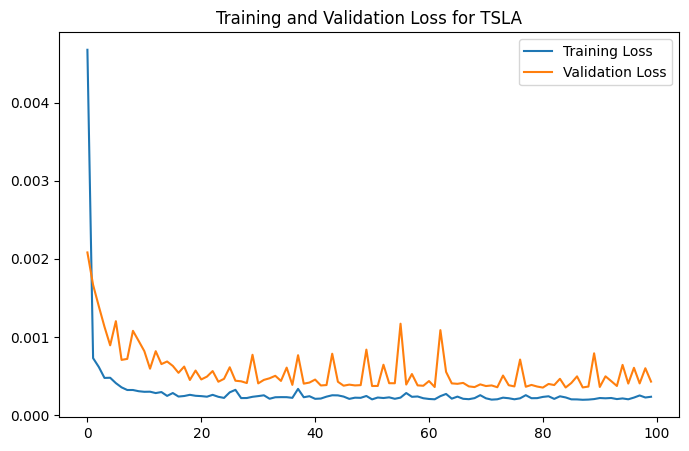

In [8]:
# Function to build the CNN-LSTM model
def build_cnn_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dense(1))  # Output layer is 1, since we're predicting only the Close price
    model.compile(optimizer='adam', loss='mse')
    return model

# Train and evaluate models for each stock
mse_results = {}
predictions_results = {}

for stock in stocks:
    # Get the split data for the current stock
    X_train, y_train, X_val, y_val, X_test, y_test = split_data[stock]

    # Build and train the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_cnn_lstm_model(input_shape)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,  # For the sake of time, you can increase this if necessary
        batch_size=32,
        verbose=1  # Set to 1 to see the training progress
    )

    # Store the trained model and history for each stock
    predictions_results[stock] = (model, history)

    # Plot training history for loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {stock}')
    plt.legend()
    plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


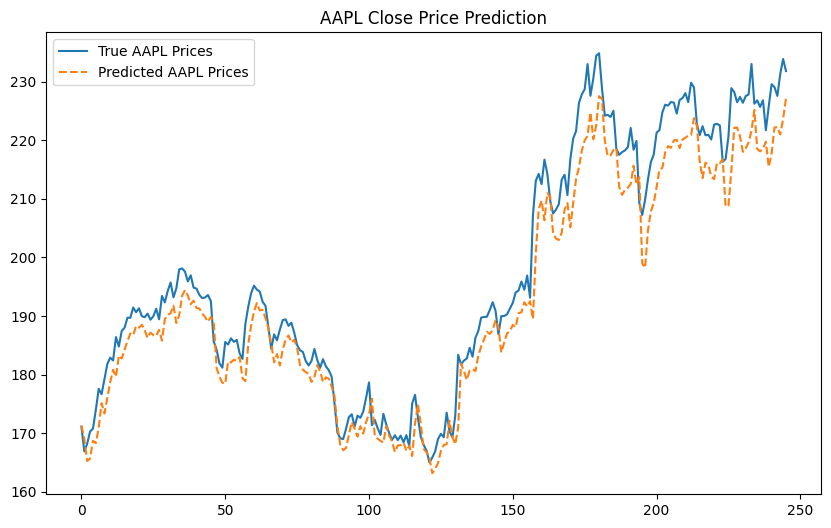

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


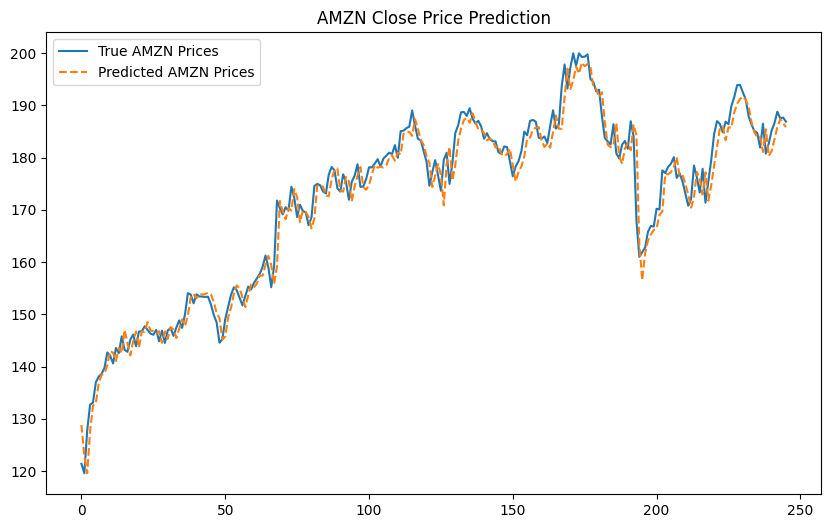

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


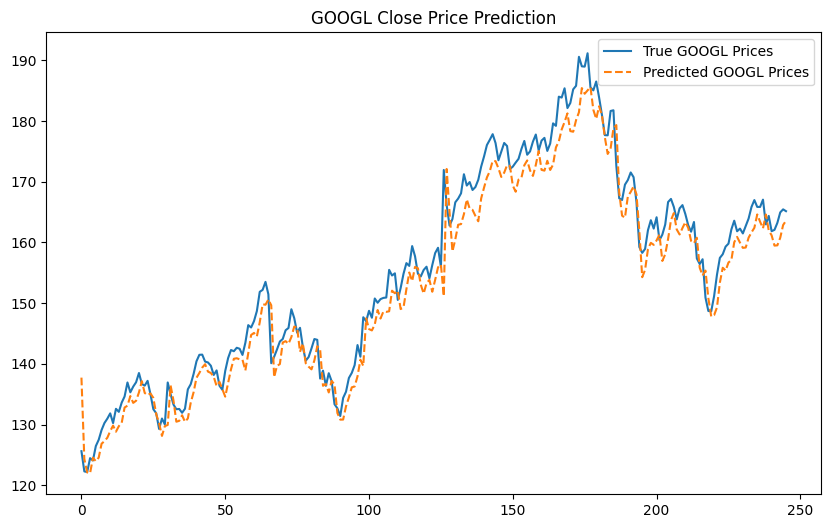

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


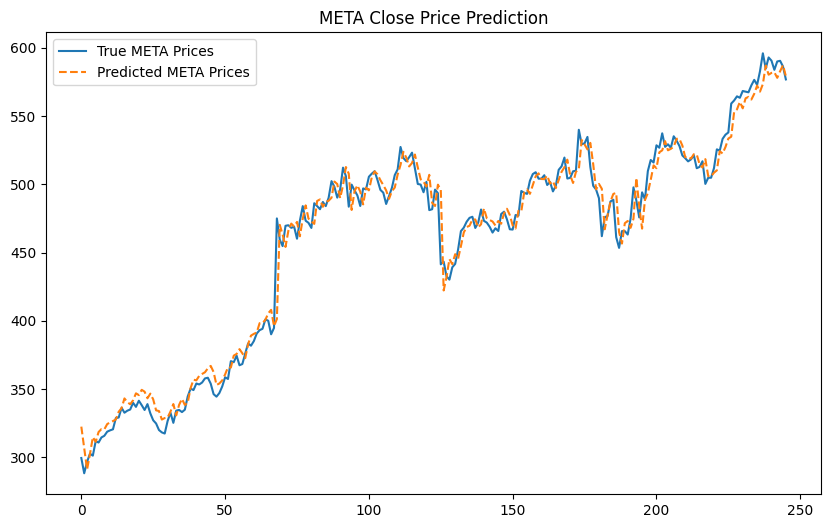

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


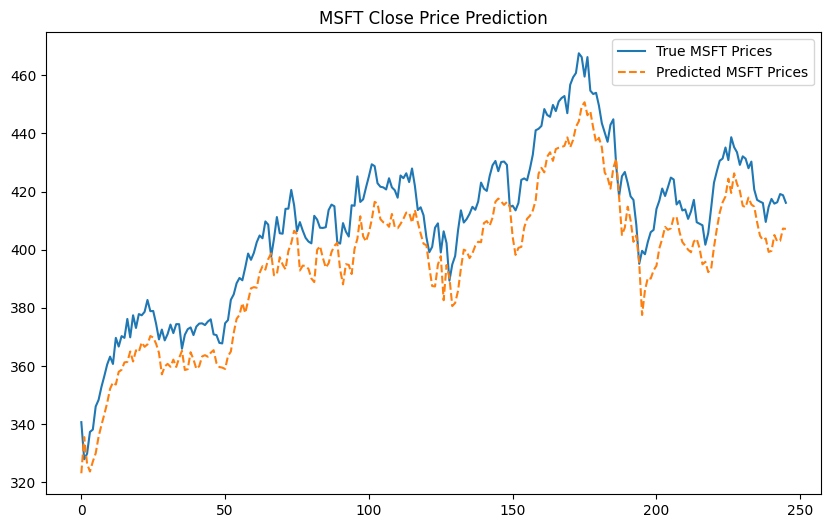

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


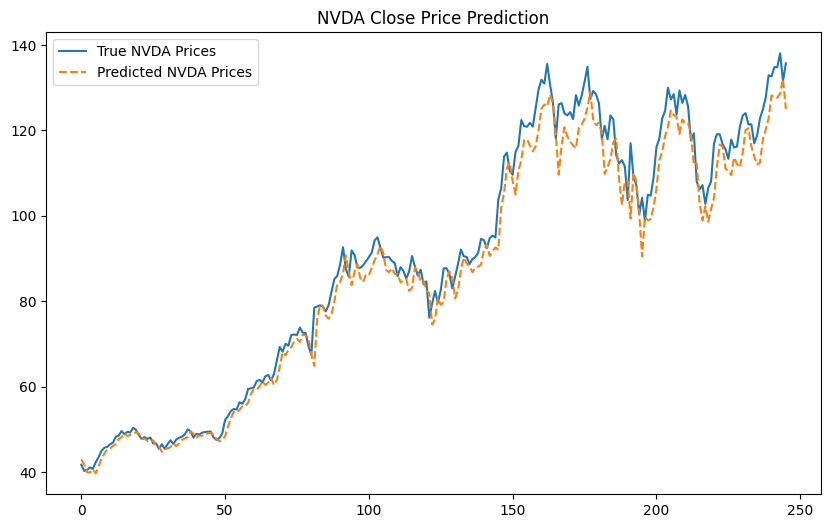

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


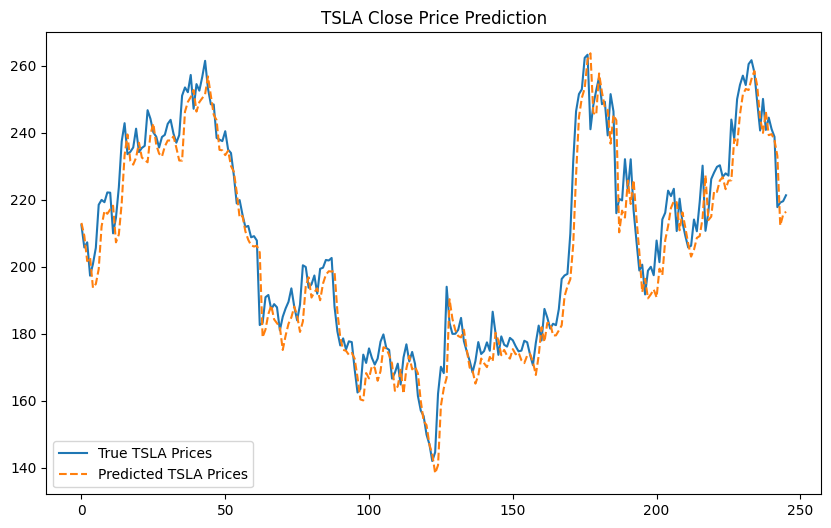

MSE for AAPL: 31.680098714676532
MSE for AMZN: 9.731106314718733
MSE for GOOGL: 14.749956523206528
MSE for META: 126.60794871730901
MSE for MSFT: 188.61016123808352
MSE for NVDA: 25.348894023523073
MSE for TSLA: 62.85031277140274


In [9]:
# Evaluate the model on test data for each stock and make predictions
for stock in stocks:
    # Get the model and split data for the stock
    model, history = predictions_results[stock]
    _, _, _, _, X_test, y_test = split_data[stock]

    # Make predictions
    predictions = model.predict(X_test)

    # Reshape the predictions and actual test data
    y_test_reshaped = y_test.reshape(y_test.shape[0], -1)
    predictions_reshaped = predictions.reshape(predictions.shape[0], -1)

    # Get the scaler for the current stock
    scaler = data_dict[stock][1]

    # Rescale the predictions and the true values back to their original scale
    predictions_rescaled = scaler.inverse_transform(
        np.hstack([np.zeros_like(predictions_reshaped)]*3 + [predictions_reshaped] + [np.zeros_like(predictions_reshaped)])
    )[:, 3]
    y_test_rescaled = scaler.inverse_transform(
        np.hstack([np.zeros_like(y_test_reshaped)]*3 + [y_test_reshaped] + [np.zeros_like(y_test_reshaped)])
    )[:, 3]

    # Calculate and store the MSE
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mse_results[stock] = mse

    # Plot the true vs predicted values for the stock
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label=f'True {stock} Prices')
    plt.plot(predictions_rescaled, label=f'Predicted {stock} Prices', linestyle='--')
    plt.legend()
    plt.title(f'{stock} Close Price Prediction')
    plt.show()

# Display the MSE results for each stock
for stock, mse in mse_results.items():
    print(f'MSE for {stock}: {mse}')
